In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Move all the files from Google drive to GPU storage
!cp "drive/MyDrive/ColabNotebooks/Thesis_Facial_expression_recognition/PytorchNotebooks/data_loaders.py" .
!cp "drive/MyDrive/ColabNotebooks/Thesis_Facial_expression_recognition/PytorchNotebooks/deep_emotion.py" .
!cp "drive/MyDrive/ColabNotebooks/Thesis_Facial_expression_recognition/PytorchNotebooks/generate_data.py" .

In [ ]:
# Import al required libraries

from __future__ import print_function
import argparse
import os
import pandas as pd
import numpy  as np
from PIL import Image
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms
import torchvision.datasets as datasets

from data_loaders import Plain_Dataset, eval_data_dataloader
from deep_emotion import Deep_Emotion
from generate_data import Generate_data

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def save_images(datapath, datatype='train'):
    """
    Helper function to read strings from csv file and save as images in the folder
        params:-
            datatype = type of data to be saved. Default value is train
    """
    foldername = datapath + "/" + datatype
    csvfile_path = datapath + "/" + datatype + '.csv'
    if not os.path.exists(foldername):
        os.mkdir(foldername)

    data = pd.read_csv(csvfile_path)
    data = data.rename(columns=lambda x: x.strip())
    images = data['pixels']  # dataframe to series pandas
    numberofimages = images.shape[0]
    for index in tqdm(range(numberofimages)):
        img = str_to_image(images[index])
        img.save(os.path.join(foldername, '{}{}.jpg'.format(datatype, index)), 'JPEG')
    print('Done saving {} data'.format((foldername)))

def str_to_image(str_img=' '):
    """
    Helper function to convert pixels to images
        params:-
            str_img = pixel values in string format
    """
    imgarray_str = str_img.split(' ')
    imgarray = np.asarray(imgarray_str, dtype=np.uint8).reshape(48, 48)
    return Image.fromarray(imgarray)

In [ ]:
# Generate data, split into train, validation and test datasets and save in respective folders

datapath = 'drive/MyDrive/ColabNotebooks/Thesis_Facial_expression_recognition/data'
generate_dataset = Generate_data(datapath)
generate_dataset.split_data()
save_images(datapath, 'train')
save_images(datapath, 'finaltest')
save_images(datapath, 'val')

Done splitting the file into training, validation & final test file


100%|██████████| 28709/28709 [02:25<00:00, 197.09it/s]


Done saving drive/MyDrive/ColabNotebooks/Thesis_Facial_expression_recognition/data/train data


100%|██████████| 3589/3589 [00:21<00:00, 168.20it/s]


Done saving drive/MyDrive/ColabNotebooks/Thesis_Facial_expression_recognition/data/finaltest data


100%|██████████| 3589/3589 [00:21<00:00, 168.19it/s]

Done saving drive/MyDrive/ColabNotebooks/Thesis_Facial_expression_recognition/data/val data


In [ ]:
#Model hyperparameters

epochs = 50
lr = 0.0005
batchsize = 256

In [ ]:
#Load the network architecture and load data from respective folders

net = Deep_Emotion()
net.to(device)
print("Model archticture: ", net)
traincsv_file = datapath+'/'+'train.csv'  #remove
validationcsv_file = datapath+'/'+'val.csv'
train_img_dir = datapath+'/'+'train/'
validation_img_dir = datapath+'/'+ 'val/'

Model archticture:  Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
# Apply transformations and create a Pytorch dataset

# transformation= transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
#                                     #transforms.RandomCrop(44, padding=4),
#                                     transforms.RandomRotation(degrees=10),
#                                     #transforms.CenterCrop((40,40)),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize((0.5,),(0.5,))])
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_dataset= Plain_Dataset(csv_file=traincsv_file, img_dir = train_img_dir, datatype = 'train', transform = transformation)
validation_dataset= Plain_Dataset(csv_file=validationcsv_file, img_dir = validation_img_dir, datatype = 'val', transform = transformation)

In [ ]:
# Define class weights as per the number of samples in each class for FER-2013 dataset

cweights = [0.1391549688251071, 0.01518687519593159, 0.14270786164617366, 0.2513149186666202, 0.16823992476226968, 0.11045316799609878, 0.17294228290779895]
class_weights = torch.FloatTensor(cweights).cuda()

# Create sample weights for training dataset
sample_weights_train = [0] * len(train_dataset.lables)
train_labels = train_dataset.lables

for i in range(0,len(train_labels)):
  label = train_labels[i]
  weight = cweights[label]
  sample_weights_train[i] = weight

In [ ]:
# Create sample weights for validation dataset
sample_weights_validation = [0] * len(validation_dataset.lables)
validation_labels = validation_dataset.lables

for i in range(0,len(validation_labels)):
  label = validation_labels[i]
  weight = cweights[label]
  sample_weights_validation[i] = weight

In [ ]:
# Apply weighted random sampler to treat imbalance problem in FER-2013 dataset

train_sampler = WeightedRandomSampler(sample_weights_train, num_samples=len(sample_weights_train), replacement=True)
train_loader= DataLoader(train_dataset,batch_size=batchsize,num_workers=0, sampler= train_sampler)

validation_sampler = WeightedRandomSampler(sample_weights_validation, num_samples=len(sample_weights_validation), replacement=True)
val_loader=   DataLoader(validation_dataset,batch_size=batchsize,num_workers=0, sampler= validation_sampler)

In [ ]:
# Define loss function and optimizer

criterion= nn.CrossEntropyLoss(weight=class_weights)
#optmizer= optim.Adam(net.parameters(),lr= lr, weight_decay=.001)
optmizer= optim.Adam(net.parameters(),lr= lr)
writer = SummaryWriter(datapath+'/runs/fer2013_experiment_25_Dropout_lr0.0005_256')

In [ ]:
# Train the network architecture using train dataset and validate using validation dataset

start_time = time.time()
train_loss_values = []
validation_loss_values = []

train_acc_values = []
validation_acc_values = []

print("===================================Start Training===================================")
for e in range(epochs):
    train_loss = 0
    validation_loss = 0
    train_correct = 0
    val_correct = 0
    # Train the model  #
    net.train()
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optmizer.zero_grad()
        outputs = net(data)
        loss = criterion(outputs,labels)
        loss.backward()
        optmizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs,1)
        train_correct += torch.sum(preds == labels.data)

    #validate the model#
    net.eval()
    for data,labels in val_loader:
        data, labels = data.to(device), labels.to(device)
        val_outputs = net(data)
        val_loss = criterion(val_outputs, labels)
        validation_loss += val_loss.item()
        _, val_preds = torch.max(val_outputs,1)
        val_correct += torch.sum(val_preds == labels.data)

    train_loss = train_loss/len(train_dataset)
    train_loss_values.append(train_loss)

    train_acc = train_correct.double() / len(train_dataset)
    train_acc_values.append(train_acc)

    validation_loss =  validation_loss / len(validation_dataset)
    validation_loss_values.append(validation_loss)

    val_acc = val_correct.double() / len(validation_dataset)
    validation_acc_values.append(val_acc)

    print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Accuarcy {:.3f}% \tValidation Accuarcy {:.3f}%'
                                                        .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))
    writer.add_scalar("Loss/train", train_loss, e)
    writer.add_scalar("Accuracy/train", train_acc, e)
    writer.add_scalar("Loss/val", validation_loss, e)
    writer.add_scalar("Accuracy/val", val_acc, e)

torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
end_time = time.time()
print("Total execution time -> ",(end_time-start_time)/60)

===================================Start Training===================================


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Epoch: 1 	Training Loss: 0.00559462 	Validation Loss 0.00578398 	Training Accuarcy 37.319% 	Validation Accuarcy 40.318%
Epoch: 2 	Training Loss: 0.00524682 	Validation Loss 0.00550397 	Training Accuarcy 40.015% 	Validation Accuarcy 41.683%
Epoch: 3 	Training Loss: 0.00501442 	Validation Loss 0.00533670 	Training Accuarcy 43.335% 	Validation Accuarcy 46.392%
Epoch: 4 	Training Loss: 0.00479646 	Validation Loss 0.00499666 	Training Accuarcy 45.620% 	Validation Accuarcy 43.466%
Epoch: 5 	Training Loss: 0.00469277 	Validation Loss 0.00495693 	Training Accuarcy 47.313% 	Validation Accuarcy 45.779%
Epoch: 6 	Training Loss: 0.00454567 	Validation Loss 0.00497595 	Training Accuarcy 48.804% 	Validation Accuarcy 48.286%
Epoch: 7 	Training Loss: 0.00448741 	Validation Loss 0.00463643 	Training Accuarcy 49.267% 	Validation Accuarcy 49.847%
Epoch: 8 	Training Loss: 0.00436249 	Validation Loss 0.00510493 	Training Accuarcy 50.542% 	Validation Accuarcy 50.766%
Epoch: 9 	Training Loss: 0.00431766 	Val

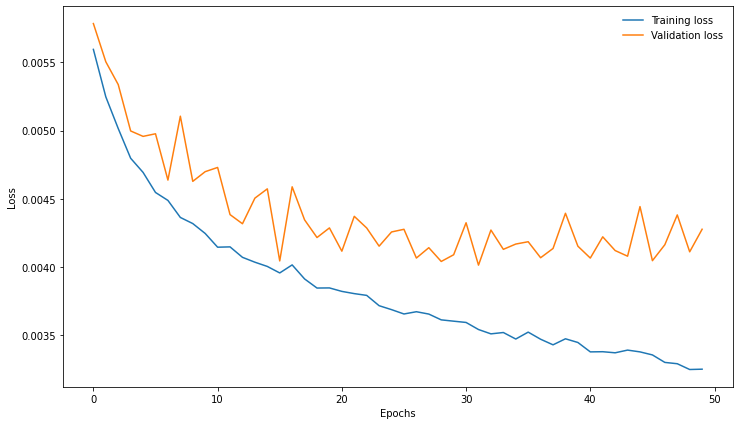

In [ ]:
# Plot for training and validation loss

plt.figure(figsize=(12,7))
plt.plot((train_loss_values), label='Training loss')
plt.plot((validation_loss_values), label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

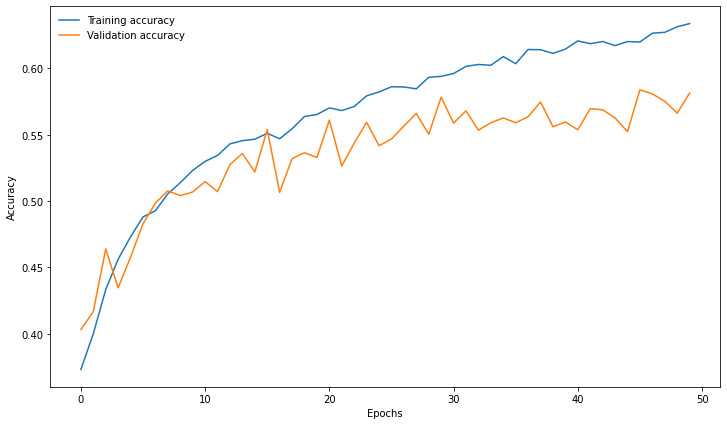

In [ ]:
# Plot for training and validation accuracy

plt.figure(figsize=(12,7))
plt.plot((train_acc_values), label='Training accuracy')
plt.plot((validation_acc_values), label='Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).cuda()
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
testcsv_file = datapath+'/'+'finaltest.csv'
test_img_dir = datapath+'/'+'finaltest/'

test_dataset= Plain_Dataset(csv_file=testcsv_file, img_dir = test_img_dir, datatype = 'finaltest', transform = transformation)
test_correct = 0
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)
    #test_preds = get_all_preds(net, prediction_loader)
    all_preds = torch.tensor([])
    #for batch in prediction_loader:
    for data, labels in prediction_loader:
      data, labels = data.to(device), labels.to(device)
      #images, labels = batch
      test_output = net(data)
      # all_preds = torch.cat(
      #     (all_preds, preds)
      #     ,dim=0
      # )
      _, test_preds = torch.max(test_output,1)
      test_correct += torch.sum(test_preds == labels.data)
      for t, p in zip(labels.view(-1), test_preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [ ]:
#preds_correct = get_num_correct(test_preds, test_dataset.targets)
print('total correct:', test_correct)
print('accuracy:', test_correct / len(test_dataset))
print("Confusion Matrix: ",confusion_matrix)
print("Per class accuracy : ",(confusion_matrix.diag()/confusion_matrix.sum(1))*100)

total correct: tensor(1851, device='cuda:0')
accuracy: tensor(0.5157, device='cuda:0')
Confusion Matrix:  tensor([[134.,   0.,  49.,  76., 110.,  12.,  86.],
        [ 17.,   0.,  15.,   9.,  12.,   0.,   3.],
        [ 33.,   0., 125.,  62., 144.,  33.,  99.],
        [ 14.,   0.,  30., 738.,  51.,   9.,  53.],
        [ 40.,   0.,  43.,  96., 316.,   3., 155.],
        [ 17.,   0.,  68.,  39.,  25., 219.,  47.],
        [ 29.,   0.,  35.,  87., 130.,   7., 319.]])
Per class accuracy :  tensor([28.6938,  0.0000, 25.2016, 82.4581, 48.3920, 52.7711, 52.5535])


Text(0.5, 42.0, 'Predicted label')

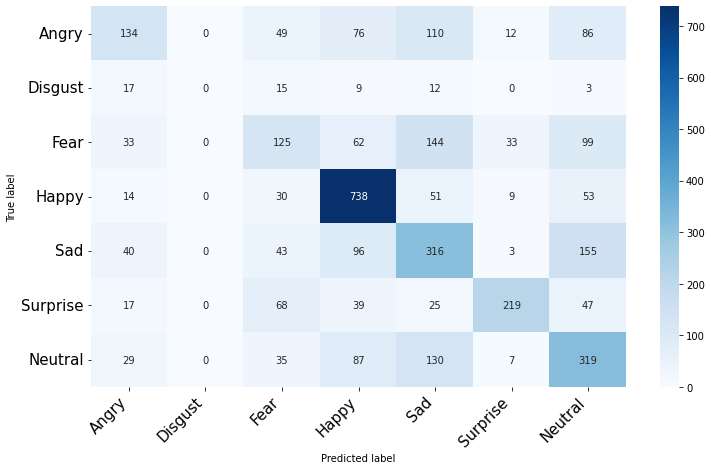

In [ ]:
plt.figure(figsize=(12,7))
class_names = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap=plt.cm.Blues)

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')